In [5]:
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# import ETHUSDT OHLC data from Binance
exchange = ccxt.binance()
response = exchange.fetch_ohlcv('ETH/USDT', '1d', limit=1500)
data = pd.DataFrame(response, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
data.date = pd.to_datetime(data['date'], unit='ms', utc=True, yearfirst=True)

In [7]:
HighestHigh = [data['high'].iloc[0]]
for i in range(1,len(data)):
    if data['high'].iloc[i] >= HighestHigh[-1]:
        HighestHigh.append(data['high'].iloc[i])
    else:
        HighestHigh.append(HighestHigh[-1])
        
data['HighestHigh'] = HighestHigh
data['DrawDown'] = data.apply(lambda row: 0 if row['high']==row['HighestHigh'] else (row['low']-row['HighestHigh'])*100/row['HighestHigh'], axis=1)



                         date    open    high   low   close        volume  \
243 2020-03-13 00:00:00+00:00  107.67  139.68  86.0  134.06  4.663240e+06   

     HighestHigh   DrawDown  
243       288.41 -70.181339  


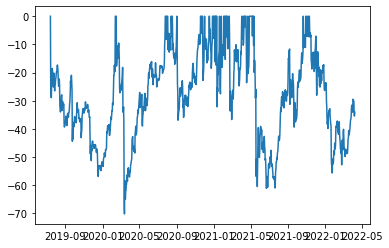

In [8]:
plt.plot(data['date'], data['DrawDown'])
print( data.loc[data['DrawDown'] == min(data['DrawDown']) ,:] )  

<AxesSubplot:>

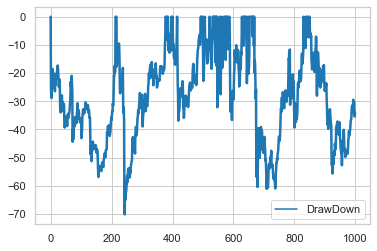

In [9]:
sns.set_theme(style="whitegrid")
sns.lineplot(data=data.loc[:,['DrawDown']], palette="tab10", linewidth=2.5)
